In [1]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 6, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Devan O'Boyle"
STUDENT_ID = "1829932"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [3]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2022-11-07 07:04:48--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  22.8MB/s    in 0.3s    

2022-11-07 07:04:49 (22.8 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [4]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()
# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

In [5]:
print(len(full_dat_out))
full_dat_out.describe()

4000


,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,64.247500,0.561921,169.787227,83.043044,134.017937,87.159565,36.956125,57.351445,118.591225,59.543420,...,4.135057,138.859128,0.549199,11.604248,137605.122000,14.961680,6.678942,13.661675,351.063772,0.138500
std,17.560946,0.496027,14.637111,23.118025,117.228862,14.488338,0.727350,10.920285,16.531284,8.927074,...,0.487365,4.052678,0.104083,3.229533,2923.608886,5.053809,3.950194,12.115969,321.616216,0.345467
min,15.000000,0.000000,1.800000,3.500000,0.000000,42.784314,21.644615,0.000000,0.000000,0.000000,...,2.500000,111.500000,0.276000,3.000000,132539.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,52.750000,0.000000,169.787227,68.201596,74.066176,77.274047,36.614286,50.492284,111.082108,55.860440,...,3.800000,136.500000,0.500000,9.307692,135075.750000,11.000000,4.000000,6.000000,298.000000,0.000000
50%,67.000000,1.000000,169.787227,82.000000,113.852484,86.617585,36.963636,57.351445,118.591225,59.543420,...,4.100000,138.859128,0.549199,12.333333,137592.500000,15.000000,6.678942,10.000000,351.063772,0.000000
75%,78.000000,1.000000,170.200000,93.058712,160.397104,96.465443,37.364603,63.168478,123.502049,62.213890,...,4.400000,141.000000,0.562500,14.750000,140100.250000,18.000000,9.000000,17.000000,351.063772,0.000000
max,90.000000,1.000000,431.800000,300.000000,3082.380952,137.842105,39.748980,107.500000,181.725000,106.666667,...,7.600000,164.533333,1.000000,15.000000,142673.000000,34.000000,22.000000,154.000000,2600.000000,1.000000


### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



The input size is 4000. There are 25 parameters in the data. The code above is reading in the data (including the outcome data) and inputting it all into a dataframe. It also is attempting to clean the data by setting all of the NaN values to the mean of the column that they're in. This way the data is ready to go for us to use going forward.

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [6]:
from sklearn.linear_model import LogisticRegression
full_dat_out = full_dat_out.drop(columns=['NIDiasABP', 'SysABP', 'DiasABP', 'Urine', 'pH', 'Platelets', 'MAP', 'K', 'Na', 'FiO2', 'GCS', 'RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival'])
train, validate, test = np.split(full_dat_out.sample(frac=1, random_state=42), [int(.6*len(full_dat_out)), int(.8*len(full_dat_out))])

x_train = train.loc[:, train.columns != 'In-hospital_death'].to_numpy()
y_train = train[['In-hospital_death']].to_numpy()

x_valid = validate.loc[:, train.columns != 'In-hospital_death'].to_numpy()
y_valid = validate[['In-hospital_death']].to_numpy()

x_test = test.loc[:, train.columns != 'In-hospital_death'].to_numpy()
y_test = test[['In-hospital_death']].to_numpy()

# Function to perform linear regression classification
def perform_logistic_regression(x_train, y_train, x_valid, y_valid, x_test, y_test):
    
    # Training a logistic regression model on the training data
    clf = LogisticRegression().fit(x_train, y_train)

    # Checking the accuracy of the model on both training and test data
    print('Training Score:  ', clf.score(x_train, y_train))
    print('Validation Score:', clf.score(x_valid, y_valid))
    print('Test Score:      ', clf.score(x_test,  y_test))

    return clf

clf = perform_logistic_regression(x_train, 
                                  y_train.astype(int).reshape((y_train.shape[0],)), 
                                  x_valid, 
                                  y_valid.astype(int).reshape((y_valid.shape[0],)),
                                  x_test, 
                                  y_test.astype(int).reshape((y_test.shape[0],))) 

Training Score:   0.8625
Validation Score: 0.84875
Test Score:       0.8725


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


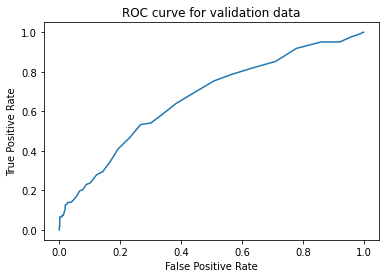

In [7]:
import matplotlib.pyplot as plt

def get_probs(clf, x):
    num_items = x.shape[0]
    return np.array([clf.predict_proba(x)[i, 1] for i in range(num_items)])

def predict_with_threshold(probs, thresh=0.5):
    return np.array([(p > thresh)*1 for p in probs])

def false_and_true_positives(preds, labels):
    n = len(labels)
    true = false = pos = neg = 0
    for i in range(len(labels)):
        if labels[i] == 1:  pos += 1
        if labels[i] == 0:  neg += 1
        if (preds[i] == 1) and (labels[i] == 1):  true  += 1
        if (preds[i] == 1) and (labels[i] == 0):  false += 1
    return false / neg, true / pos

# Get the raw prediction probabilities.
val_probs = get_probs(clf, x_valid)

false_positives, true_positives = [], []
for t in np.linspace(0., 1., 100):
    val_preds = predict_with_threshold(val_probs, thresh=t)
    false_pos, true_pos = false_and_true_positives(val_preds, y_valid)
    false_positives.append(false_pos)
    true_positives.append(true_pos)

plt.plot(false_positives, true_positives)
plt.title('ROC curve for validation data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


Based on the plot, the false positive rate looks to be around 60%. The high false positive would be appropriate since we are classifying a binary outcome: either the patient died or they didn't, based on data that consists of numerous features with a high amount of variance. The model doesn't have the luxury of saying the patient was 54% dead, in which case that patient may very well be alive. Rather through logistic regression it uses the data given to classify patients as dead or alive to the best of its ability.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [8]:
import math

#1
t = 60/25
print("Problem 1")
print(math.exp(-(t*t)/100))
print("Number of deaths: " + str(math.exp(-(t*t)/100) * 10))
print(math.exp(-(t*t)/100) * 10 / 25)

#2
print("Problem 2")
print(x_valid.shape[0])
t = (x_valid.shape[0]/25 * 60)/x_valid.shape[0]
death_chance = math.exp(-(t*t)/100)
print(death_chance)

death_possible = 0;
total = 0
for x in y_valid:
    if x == 1:
        death_possible += 1
    total += 1
print(death_possible)
print(death_chance*death_possible)

#3
print("Problem 3")
p_pred = clf.predict_proba(x_valid)

total_counted = 0
counted = 0
not_counted = 0
i = 0
for x in p_pred:
    if x[1] > 0.2:
        if y_train[i] == 1:
            counted += 1
        total_counted += 1
    else:
        if y_train[i] == 1:
            not_counted += 1
    i += 1
t = (total/25 * 60)/total_counted
print("over: ", counted)
print("under: ", not_counted)
death_chance = math.exp(-(t*t)/100)
print(death_chance)
print(death_chance * counted + not_counted)


Problem 1
0.9440274829178357
Number of deaths: 9.440274829178357
0.37761099316713426
Problem 2
800
0.9440274829178357
122
115.17135291597594
Problem 3
over:  26
under:  95
0.1362751078285503
98.54315280354231


1. At least 9 patients are expected to die since the chance for any patient to die is 94.4%. This gives us 37.7% of patients who are expected to die.

2. At least 115 patients are expected to die since there is a 94.4% chance for any patient to die and there are 122 patients with a chance of dying if not treated properly.

3. At least 98 patients are expected to die.

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




Best threshold:  0.18
Least deaths: 96.24202262353485


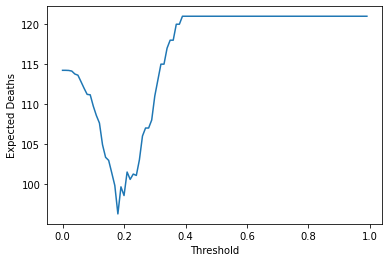

In [9]:
expected_deaths = np.array([])
thresholds = np.arange(0, 1, 0.01)

min_deaths = 0
min_threshold = 0
for e in thresholds:
    p_pred = clf.predict_proba(x_valid)
    total_counted = 0
    counted = 0
    not_counted = 0
    i = 0
    for x in p_pred:
        if x[1] > e:
            if y_train[i] == 1:
                counted += 1
            total_counted += 1
        else:
            if y_train[i] == 1:
                not_counted += 1
        i += 1
    if total_counted == 0:
        t = 0
    else:
        t = (total/25 * 60)/total_counted
    death_chance = math.exp(-(t*t)/100)
    expected = death_chance * counted + not_counted
    if e == 0:
        min_deaths = expected
        min_threshold = 0
    elif expected < min_deaths:
        min_deaths = expected
        min_threshold = e

    expected_deaths = np.append(expected_deaths, expected)
    
    
print("Best threshold: ", min_threshold)
print("Least deaths:", min_deaths)
plt.plot(thresholds, expected_deaths)
plt.xlabel('Threshold')
plt.ylabel('Expected Deaths')
plt.show()

The best threshold is 18%, since that models the least number of expected deaths at around 96.

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [10]:
p_pred = clf.predict_proba(x_test)

total_counted = 0
counted = 0
not_counted = 0
i = 0
for x in p_pred:
    if x[1] > min_threshold:
        if y_test[i] == 1:
            counted += 1
        total_counted += 1
    else:
        if y_test[i] == 1:
            not_counted += 1
    i += 1
t = (total/25 * 60)/total_counted
print("over: ", counted)
print("under: ", not_counted)
death_chance = math.exp(-(t*t)/100)
print(death_chance)
policy = death_chance * counted + not_counted
print("Deaths under policy: ", policy)

death_possible = 0;
for x in y_test:
    if x == 1:
        death_possible += 1
print("Deaths without policy: ", death_possible)
percentage_policy = policy/800
percentage_without = death_possible/800
print("Percentage died without policy: ", percentage_without)
print("Percentage died with policy: ", percentage_policy)
print("Difference: ", percentage_without - percentage_policy)

over:  44
under:  59
0.37550341077919613
Deaths under policy:  75.52215007428464
Deaths without policy:  103
Percentage died without policy:  0.12875
Percentage died with policy:  0.0944026875928558
Difference:  0.0343473124071442


At least 27 lives would be saved under the policy. Overall, this means that around 3.43% of more people live.



## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [5]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [6]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
# Download the data
downloaded = drive.CreateFile({'id':"1NXiYkupBcolg90e6wE_Nm_F9VTFoXIja"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [9]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])

In [10]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

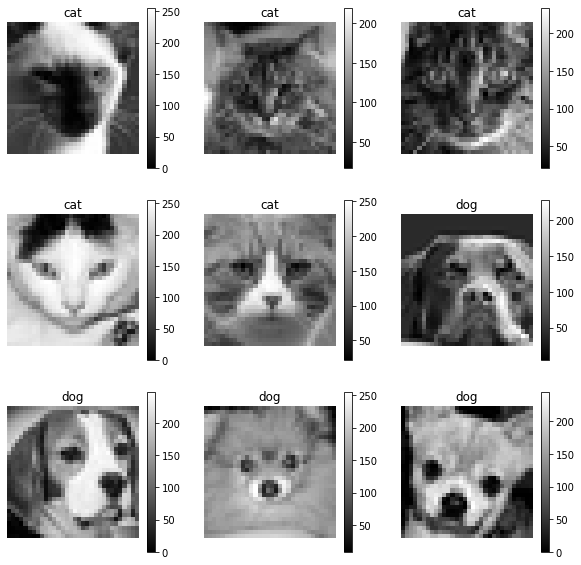

In [11]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

In [12]:
print(X.shape)
print(y.shape)

(110, 32, 32)
(110,)


Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

1. The data type of X is a 2d numpy array that contains values that represent the grey-scale color values for the images. The data type of y is a binary numerical value that tells whether the image is a dog or cat.
2. The shape of X is (110, 32, 32) and y is (110,).
3. The minimum value of X is 0 and the maximum is 255.

### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [13]:
train_images =  np.array([x/225 for x in X])

If we show the image agian, you will see the values are all scaled correctly.

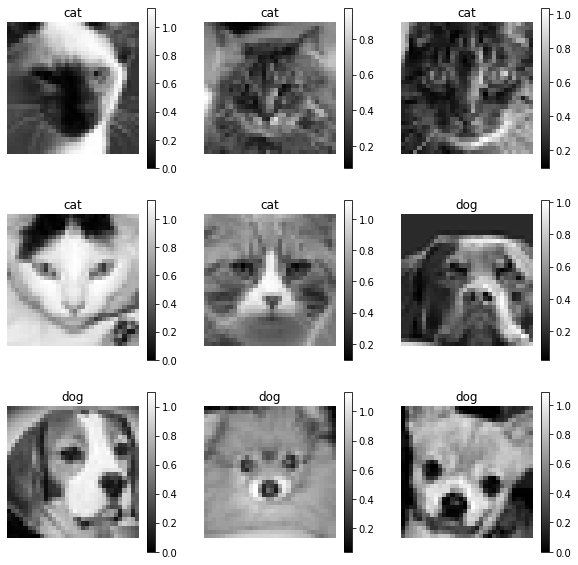

In [14]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

What is the new minimum and maximum value of X?

min: 0
max: 1

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [15]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images = train_images.reshape((110, 1024))

print(f'Before reshape, train_images shape: {train_images.shape}')


Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [16]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

# Build neural network
input_layer = Input(shape=(1024))
x = Dense(25, activation='relu')(input_layer)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_layer, x)



In [17]:
# Show a summary of your model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 25)                25625     
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [18]:
# Declare optimizer
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [19]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images,
                 y, 
                 epochs=500, 
                 batch_size=10, 
                 validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 2s 49ms/step - loss: 0.7168 - accuracy: 0.4646 - val_loss: 0.6626 - val_accuracy: 0.5455
Epoch 2/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6913 - accuracy: 0.4747 - val_loss: 0.7153 - val_accuracy: 0.4545
Epoch 3/500
10/10 [==============================] - 0s 13ms/step - loss: 0.6805 - accuracy: 0.5354 - val_loss: 0.7393 - val_accuracy: 0.2727
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 0.6725 - accuracy: 0.5758 - val_loss: 0.7586 - val_accuracy: 0.1818
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6667 - accuracy: 0.5758 - val_loss: 0.7595 - val_accuracy: 0.1818
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6625 - accuracy: 0.5758 - val_loss: 0.7620 - val_accuracy: 0.1818
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6576 - accuracy: 0.5758 - val_loss: 0.7638 - val_accuracy: 0.1818
Epoch 8/

In [20]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

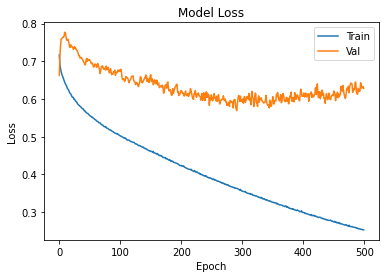

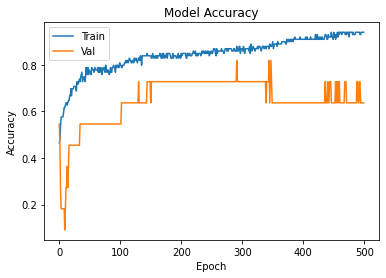

In [21]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

From epoch 0 to 100, the model's accuracy on the training data increases all the way from 40% to 80% and only increases steadily from then on. The accuracy model has a similar shape to that of the loss model except that the model decreases whereas the accuracy increases. As the epoch increases to 500, the loss on the training data reaches close 0. This makes sense because the greater the epoch value, the more times we iterate over the training data, bringing us closer to our desired outcome each time.

For the validation data, we can see that the loss starts at around 80% and then drops down to less than 70%, but then it oscillates its way back up to just above 70%. We can also see that for the validation set it the accuracy doesn't increase quite as quickly and caps out around 70% as opposed to the training data's near 100%.

### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [29]:
# Build Neural network
input_layer = Input(shape=(1024))
x = Dense(100, activation='relu')(input_layer)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_layer, x)

In [30]:
# Show a summary of your model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 100)               102500    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [31]:
# Declare optimizer
optimizer =  SGD(learning_rate=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [32]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist = model.fit(train_images,
                 y, 
                 epochs=500, 
                 batch_size=10, 
                 validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 0.7144 - accuracy: 0.4545 - val_loss: 0.7504 - val_accuracy: 0.3636
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7022 - accuracy: 0.5152 - val_loss: 0.7267 - val_accuracy: 0.4545
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.4747 - val_loss: 0.7565 - val_accuracy: 0.2727
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5253 - val_loss: 0.7483 - val_accuracy: 0.3636
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6755 - accuracy: 0.5354 - val_loss: 0.7417 - val_accuracy: 0.3636
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6700 - accuracy: 0.5455 - val_loss: 0.7607 - val_accuracy: 0.3636
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6618 - accuracy: 0.5556 - val_loss: 0.7670 - val_accuracy: 0.2727
Epoch 8/500


In [33]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

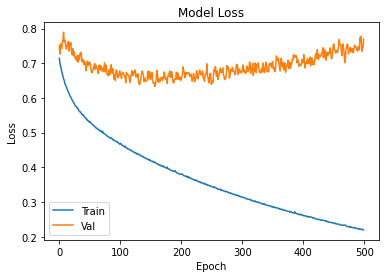

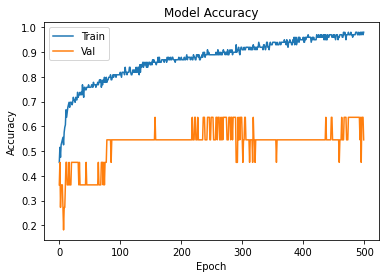

In [34]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

This model was very similar to the last, especially with the training data. The validation on the other hand seems to have had some slight improvements. For instance, the loss function seems to decrease slightly more than before reaching a value closer to 70% or less vs the just over 70% from before. Also the accuracy seems to reach a higher value of around 80% as opposed to the 70% from before. Given this imporation, it looks like this model outperformed the original. Particularly since the overall classification accuracy on the validation set reached around 80% and reached a loss as little as around 60%.

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [35]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
input_layer = Input(shape=(1024))
x = Dense(100, activation='relu')(input_layer)
x = Dense(25, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(input_layer, x)

In [36]:
# Show a summary of your model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_4 (Dense)             (None, 100)               102500    
                                                                 
 dense_5 (Dense)             (None, 25)                2525      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 105,051
Trainable params: 105,051
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [37]:
# Declare optimizer
optimizer = Adam(learning_rate=0.001)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [38]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist = model.fit(train_images,
                 y, 
                 epochs=500, 
                 batch_size=10, 
                 validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 28ms/step - loss: 0.7108 - accuracy: 0.5657 - val_loss: 0.8055 - val_accuracy: 0.0909
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 0.5872 - accuracy: 0.7172 - val_loss: 0.8214 - val_accuracy: 0.2727
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 0.5464 - accuracy: 0.7071 - val_loss: 0.8339 - val_accuracy: 0.2727
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.5347 - accuracy: 0.7374 - val_loss: 0.5666 - val_accuracy: 0.7273
Epoch 5/500
10/10 [==============================] - 0s 9ms/step - loss: 0.4488 - accuracy: 0.7778 - val_loss: 0.2671 - val_accuracy: 1.0000
Epoch 6/500
10/10 [==============================] - 0s 11ms/step - loss: 0.4483 - accuracy: 0.7778 - val_loss: 0.8478 - val_accuracy: 0.5455
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3880 - accuracy: 0.8384 - val_loss: 0.5670 - val_accuracy: 0.7273
Epoch 8/50

In [2]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

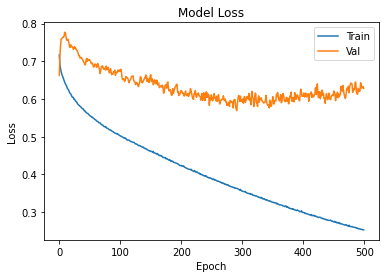

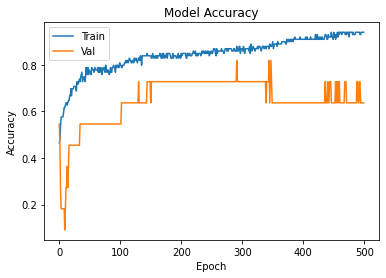

In [23]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

Overall, the training data performed far better reaching complete 100% accuracy with less than 50 epochs from the looks of it. The same can't be said of the validation set which performed significantly worse than before. For one, despite the training data quickly reaching zero loss, the validation data started at a minimum of around 50% but then continuously increased with loss as opposed to the steady decline then slight incline from before. As for the accuracy, the validation oscillates a bit the beginning but then quickly caps off around 50% or less which is worse compared to the near 80% from before. Overall, this model performed worse, and leaves signs of overfitting of the data. This is due to using Adam as an optimizer which over optimized the training data causing it to converge too quickly to a minima.